
# RUN VCE - better in separate script

In [17]:
# import torch
# import numpy as np
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# from matplotlib.offsetbox import AnnotationBbox, OffsetImage
# from tqdm import tqdm
# from omegaconf import OmegaConf
# import umap
# from models import JointLatentDiffusionMultilabel, MultilabelClassifier
# from datasets import ChestXRay_nih_bbox
# import torchvision as tv
# from ldm.util import default
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# from einops import rearrange, repeat
# from ldm.models.diffusion.ddim import DDIMSampler
# import os

# os.environ["CUDA_VISIBLE_DEVICES"]="1"
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")



In [18]:
# # config = OmegaConf.load("logs/a2_jd_classweight0_001_JointLatentDiffusionMultilabel_2024-02-08T16-53-13/configs/config.yaml")
# # config.model.params["ckpt_path"] = f"logs/a2_jd_classweight0_001_JointLatentDiffusionMultilabel_2024-02-08T16-53-13/checkpoints/last.ckpt"

# # config = OmegaConf.load("logs/a7_jd_lr10_4_bcew_JointLatentDiffusionMultilabel_2024-02-09T03-14-54/configs/config.yaml")
# # config.model.params["ckpt_path"] = f"logs/a7_jd_lr10_4_bcew_JointLatentDiffusionMultilabel_2024-02-09T03-14-54/checkpoints/last.ckpt"

# config = OmegaConf.load("logs/a8_jd_lr10_4_14cls_JointLatentDiffusionMultilabel_2024-02-09T07-02-07/configs/config.yaml")
# config.model.params["ckpt_path"] = f"logs/a8_jd_lr10_4_14cls_JointLatentDiffusionMultilabel_2024-02-09T07-02-07/checkpoints/last.ckpt"

# model = JointLatentDiffusionMultilabel(**config.model.get("params", dict()))
# model.sampling_method='conditional_to_x'
# model.sample_grad_scale=40
# model.to("cuda")
# model.eval()



In [19]:
# torch.set_printoptions(sci_mode=False)
# config = OmegaConf.load("/home/jk/Joint-Diffusion-in-Latent-Space/logs/d14_resnet_aug8_100_MultilabelClassifier_2024-02-08T23-03-18/configs/config.yaml")
# ckpt_path = f"/home/jk/Joint-Diffusion-in-Latent-Space/logs/d14_resnet_aug8_100_MultilabelClassifier_2024-02-08T23-03-18/checkpoints/last.ckpt"

# model_2 = MultilabelClassifier(**config.model.get("params", dict()))
# checkpoint = torch.load(ckpt_path)
# model_2.load_state_dict(checkpoint["state_dict"])
# model_2.to("cuda")
# model_2.eval()

In [20]:
# def embed_imgs(model, data_loader, max_samples=100000):
#     # Encode all images in the data_laoder using model, and return both images and encodings
#     img_list, embed_list, bbox_list, label_list = [], [], [], []

#     for imgs, bbox, label in tqdm(data_loader):
#         if len(imgs.shape) == 3:
#             imgs = imgs[..., None]
#         imgs = rearrange(imgs, 'b h w c -> b c h w')

#         with torch.no_grad():
#             encoder_posterior = model.encode_first_stage(imgs.to(device))
#             latent = model.get_first_stage_encoding(encoder_posterior).detach()
#             img_list.append(imgs.cpu())
#             embed_list.append(latent.cpu())
#             bbox_list.append(bbox)
#             label_list.append(label)
#         if max_samples is not None and len(img_list) > max_samples:
#             break
#     return (img_list, embed_list, bbox_list, label_list)

In [14]:
# cl_list = ["Atelectasis","Cardiomegaly","Consolidation","Edema","Effusion","Emphysema","Fibrosis", "Hernia","Infiltration", "Mass", "Nodule","Pleural_Thickening","Pneumonia","Pneumothorax","No Finding"]
# cl_list_loop=cl_list.copy()
# T = 10
# num_timesteps = 1000
   


In [ ]:
# for class_ in cl_list_loop:
#     dataset = ChestXRay_nih_bbox(pick_class=class_)
#     if len(dataset)>0:
#         print(class_, 'has N samples: ', len(dataset))
#         dl = torch.utils.data.DataLoader(dataset, batch_size=min(len(dataset), 32), shuffle=False)

#         ret = embed_imgs(model, dl)
#         batch = 0
#         x_samples_save = []
#         img_original_save = []
#         pred_o_save = []
#         pred_o_ext_save = []
#         pred_ext_save = []
#         bbox_save = []


#         for img_original, z, bbox in zip(ret[0], ret[1], ret[2]):
#             # denoise samples
#             z = z.to("cuda")
#             t = repeat(torch.tensor([T]), '1 -> b', b=len(z))
#             t = t.to("cuda").long()
#             noise = torch.randn_like(z)
#             z_noisy = model.q_sample(x_start=z, t=t, noise=noise)
#             shape = z_noisy.shape            
#             samples, pred_o = model.p_sample_loop(cond=None, shape = shape, original_img = z, 
#                                                 return_intermediates=False, x_T=z_noisy, start_T=T, 
#                                                 pick_class=class_, return_pred_o=True)
#             x_samples = model.decode_first_stage(samples)
            
#             #predictions with external clasisfier
#             img_original = img_original.to("cuda")
#             pred_o_ext = model_2(img_original)
#             pred_ext = model_2(x_samples)

#             x_samples_save.append(x_samples.detach().cpu().clone())
#             del x_samples
#             img_original_save.append(img_original.detach().cpu().clone())
#             del img_original
#             pred_o_save.append(pred_o.detach().cpu().clone())
#             del pred_o
#             pred_o_ext_save.append(pred_o_ext.detach().cpu().clone())
#             del pred_o_ext
#             pred_ext_save.append(pred_ext.detach().cpu().clone())
#             del pred_ext
#             bbox_save.append(bbox.clone())
#             del bbox


#             batch+=1
#             if batch>1000:
#                 break
            
#         folder_to_save = "vce_results_2"
#         torch.save(torch.cat(x_samples_save, dim=0), f'{folder_to_save}/T{T}_{class_}_x_samples.pt')
#         del x_samples_save
#         torch.save(torch.cat(img_original_save, dim=0), f'{folder_to_save}/T{T}_{class_}_img_original.pt')
#         del img_original_save
#         torch.save(torch.cat(pred_o_save, dim=0), f'{folder_to_save}/T{T}_{class_}_pred_o.pt')
#         del pred_o_save
#         torch.save(torch.cat(pred_o_ext_save, dim=0), f'{folder_to_save}/T{T}_{class_}_pred_o_ext.pt')
#         del pred_o_ext_save
#         torch.save(torch.cat(pred_ext_save, dim=0), f'{folder_to_save}/T{T}_{class_}_pred_ext.pt')
#         del pred_ext_save
#         torch.save(torch.cat(bbox_save, dim=0), f'{folder_to_save}/T{T}_{class_}_bbox.pt')
#         del bbox_save

# PLOT IMGS

In [3]:
import torch


In [30]:
T = 350
cl_list = ["Atelectasis","Cardiomegaly","Consolidation","Edema","Effusion","Emphysema","Fibrosis", "Hernia","Infiltration", "Mass", "Nodule","Pleural_Thickening","Pneumonia","Pneumothorax","No Finding"]
folder_to_save='/Users/joannakaleta/Documents/Sano/sano_machines/vce_results_baseline'
for class_ in ["Effusion"]:
    x_samples =torch.load(f'{folder_to_save}/T{T}_{class_}_x_samples.pt')
    pred_o = torch.load(f'{folder_to_save}/T{T}_{class_}_pred_o.pt')
    img_original = torch.load(f'{folder_to_save}/T{T}_{class_}_img_original.pt')
    pred_o_ext = torch.load(f'{folder_to_save}/T{T}_{class_}_pred_o_ext.pt')
    pred_ext = torch.load(f'{folder_to_save}/T{T}_{class_}_pred_ext.pt')
    bbox = torch.load(f'{folder_to_save}/T{T}_{class_}_bbox.pt')



In [31]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


all predictins for orig x tensor([0.1994, 0.0151, 0.0579, 0.0077, 0.3794, 0.0270, 0.0150, 0.0037, 0.1258,
        0.0660, 0.0334, 0.0544, 0.0121, 0.1439, 0.3228])
all predictins for x pred start tensor([0.2162, 0.0182, 0.0962, 0.0112, 0.2333, 0.0200, 0.0155, 0.0044, 0.1469,
        0.1466, 0.0393, 0.0475, 0.0164, 0.0628, 0.3400])
predicitons for x original, only class Effusion tensor(0.3794)
predicitons for x pred start, only class Effusion tensor(0.2333)


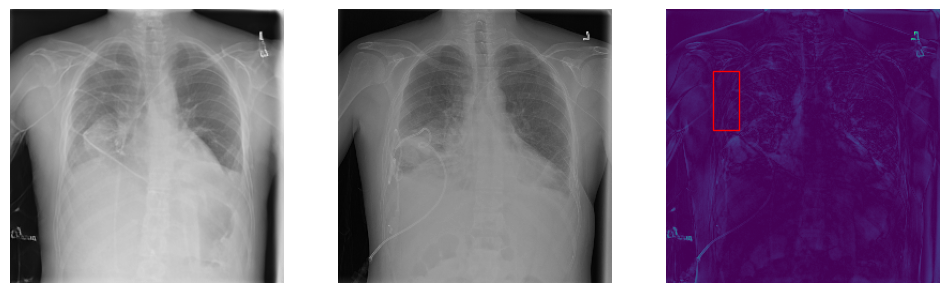

In [37]:
idx_from_batch = 13

fig, axes = plt.subplots(1, 3, figsize=(12, 4))


# Plot the images on the subplots
denoised_guided_normalized = x_samples.cpu()[idx_from_batch].permute(1,2,0)
denoised_guided = denoised_guided_normalized*0.5+0.5
img_ref_normalized = img_original.cpu()[idx_from_batch].permute(1,2,0)
img_ref = img_ref_normalized*0.5+0.5
diff = abs(denoised_guided - img_ref)

ax = 0
axes[ax].imshow(denoised_guided, cmap='gray')
axes[ax].axis('off')

ax +=1
axes[ax].imshow(img_ref, cmap='gray')
axes[ax].axis('off')

ax +=1


x, y, w, h = bbox[idx_from_batch][0], bbox[idx_from_batch][1],bbox[idx_from_batch][2], bbox[idx_from_batch][3]
# Scale the bounding box coordinates from 1024x1024 to 256x256
scaled_x = x * 0.25
scaled_y = y * 0.25
scaled_w = w * 0.25
scaled_h = h * 0.25

# Create a rectangle patch using the scaled coordinates
rect = patches.Rectangle((scaled_x, scaled_y), scaled_w, scaled_h, linewidth=1, edgecolor='r', facecolor='none')

# Add the rectangle patch to the plot
axes[ax].add_patch(rect)


axes[ax].imshow(diff)
axes[ax].axis('off')

#fig.suptitle(ret[3][0][idx_from_batch])

pred_o_ext_for_item = torch.nn.functional.sigmoid(pred_o_ext[idx_from_batch])
pred_ext_for_item = torch.nn.functional.sigmoid(pred_ext[idx_from_batch])
id_class = cl_list.index(class_)
print('all predictins for orig x', pred_o_ext_for_item)
print('all predictins for x pred start', pred_ext_for_item)
print(f'predicitons for x original, only class {cl_list[id_class]}', pred_o_ext_for_item[id_class])
print(f'predicitons for x pred start, only class {cl_list[id_class]}',pred_ext_for_item[id_class])



# TABLES

## Compare mean prediction change for all classes.   
### In index we have class to remove from image. In columns we have mean for (pred_remove_class-pred_orig). Predictions are for EXTERNAL clasisfier. 

In [94]:
import pandas

In [110]:
T = 500
min_prediction_confidence = 0.3
cl_list = ["Atelectasis","Cardiomegaly","Consolidation","Edema","Effusion","Emphysema","Fibrosis", "Hernia","Infiltration", "Mass", "Nodule","Pleural_Thickening","Pneumonia","Pneumothorax","No Finding"]
folder_to_save='/Users/joannakaleta/Documents/Sano/sano_machines/vce_results_baseline'
indexes = []
data = []
for cl_index, class_ in enumerate(cl_list):
    try:
        x_samples =torch.load(f'{folder_to_save}/T{T}_{class_}_x_samples.pt')
        pred_o = torch.load(f'{folder_to_save}/T{T}_{class_}_pred_o.pt')
        img_original = torch.load(f'{folder_to_save}/T{T}_{class_}_img_original.pt')
        pred_o_ext = torch.load(f'{folder_to_save}/T{T}_{class_}_pred_o_ext.pt')
        pred_ext = torch.load(f'{folder_to_save}/T{T}_{class_}_pred_ext.pt')
        bbox = torch.load(f'{folder_to_save}/T{T}_{class_}_bbox.pt')
        
        mask = torch.nn.functional.sigmoid(pred_o_ext[:, cl_index])>=min_prediction_confidence
        
        diff = ((torch.nn.functional.sigmoid(pred_ext[mask])-(torch.nn.functional.sigmoid(pred_o_ext[mask])))/1).mean(dim=0)
        indexes.append(class_)
        data.append(diff)
    except:
        pass

print(f"Denoising timestep {T}, min_prediction_confidence {min_prediction_confidence}")
df=pandas.DataFrame(data, columns=cl_list, index=indexes)
df= df.applymap(lambda x: x.item())
df.style.highlight_min(color = 'lightgreen', axis = 1) 


Denoising timestep 500, min_prediction_confidence 0.3


,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,No Finding
Atelectasis,-0.289219,0.007363,-0.015323,0.001480,-0.043762,-0.013619,-0.006764,-0.001555,-0.024790,-0.002106,0.005786,-0.006190,-0.004232,0.001506,0.176788
Cardiomegaly,0.055003,-0.381564,0.007649,-0.004810,-0.028793,0.014486,0.001393,-0.000041,0.015371,0.026382,0.024619,0.006313,-0.000584,0.031599,0.004261
Effusion,-0.015888,-0.013474,-0.020711,-0.002263,-0.288076,0.008200,0.002247,0.000421,-0.015222,0.004668,0.014108,-0.020372,-0.001278,0.018067,0.146132
Mass,0.011513,0.015743,-0.027569,0.002329,-0.009029,0.009490,0.008745,0.000812,0.052967,-0.542498,-0.203635,-0.014319,0.004587,0.001814,0.292525
Nodule,0.049281,0.013885,0.001486,-0.001863,0.022785,0.001488,-0.003743,0.000774,0.051614,-0.245812,-0.476364,-0.001739,-0.000438,-0.027298,0.302142
Pneumonia,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Pneumothorax,0.011141,0.015800,0.011122,0.004741,0.030026,-0.255947,0.003855,0.001057,0.046240,-0.026283,-0.034565,-0.010267,0.007164,-0.383846,0.128319


## Compare predictions only for denoised class

In [129]:
T = 500
min_prediction_confidence = 0.1
cl_list = ["Atelectasis","Cardiomegaly","Consolidation","Edema","Effusion","Emphysema","Fibrosis", "Hernia","Infiltration", "Mass", "Nodule","Pleural_Thickening","Pneumonia","Pneumothorax","No Finding"]
folder_to_save='/Users/joannakaleta/Documents/Sano/sano_machines/vce_results_baseline'
indexes = []
data = []
for cl_index, class_ in enumerate(cl_list):
    try:
        x_samples =torch.load(f'{folder_to_save}/T{T}_{class_}_x_samples.pt')
        pred_o = torch.load(f'{folder_to_save}/T{T}_{class_}_pred_o.pt')
        img_original = torch.load(f'{folder_to_save}/T{T}_{class_}_img_original.pt')
        pred_o_ext = torch.load(f'{folder_to_save}/T{T}_{class_}_pred_o_ext.pt')
        pred_ext = torch.load(f'{folder_to_save}/T{T}_{class_}_pred_ext.pt')
        bbox = torch.load(f'{folder_to_save}/T{T}_{class_}_bbox.pt')
        
        mask = torch.nn.functional.sigmoid(pred_o_ext[:, cl_index])>=min_prediction_confidence
        pred_o_ext_class = torch.nn.functional.sigmoid(pred_o_ext[:, cl_index])[mask].mean()
        pred_ext_class = torch.nn.functional.sigmoid(pred_ext[:, cl_index])[mask].mean()
        
        diff = (pred_ext_class-pred_o_ext_class)
        diff_perc = ((pred_ext_class-pred_o_ext_class)/pred_o_ext_class)*100
        n_samples = mask.sum()
        indexes.append(class_)
        data.append([pred_o_ext_class, pred_ext_class, diff, diff_perc, n_samples])
    except:
        pass

print(f"Denoising timestep {T}, min_prediction_confidence {min_prediction_confidence}")
df=pandas.DataFrame(data, columns=["mean_orig_pred", "mean_denoised_pred","abs diff", "perc diff", "n_samples"], index=indexes)
df= df.applymap(lambda x: x.item())
df#.style.highlight_min(color = 'lightgreen', axis = 0) 

Denoising timestep 500, min_prediction_confidence 0.1


,mean_orig_pred,mean_denoised_pred,abs diff,perc diff,n_samples
Atelectasis,0.271082,0.186311,-0.084771,-31.271214,126
Cardiomegaly,0.294487,0.066486,-0.228001,-77.423080,96
Effusion,0.276805,0.149617,-0.127187,-45.948364,126
Mass,0.400918,0.065733,-0.335186,-83.604485,52
Nodule,0.362124,0.063374,-0.298750,-82.499413,49
Pneumonia,NaN,NaN,NaN,NaN,0
Pneumothorax,0.377255,0.169179,-0.208076,-55.155212,69


In [125]:
pred_o_ext_class

tensor(0.5907)